# Event Sampling

## Prerequisites 

To understand how to generate a Model and a MapDataset, and how to fit the data, please refer to the `~gammapy.modeling.models.SkyModel` and [simulate_3d](simulate_3d).

## Context 

This tutorial describes how to sample events from an observation of a one (or more) gamma-ray source(s). The main aim of the tutorial will be to set the minimal configuration needed to deal with the Gammapy event-sampler and how to obtain an output photon event list.

The core of the event sampling lies into the Gammapy `~gammapy.datasets.MapDatasetEventSampler` class, which is based on the inverse cumulative distribution function [(Inverse CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Inverse_distribution_function_(quantile_function)). 

The `~gammapy.datasets.MapDatasetEventSampler` takes in input a `~gammapy.datasets.Dataset` object containing the spectral, spatial and temporal properties of the source(s) of interest.

The `~gammapy.datasets.MapDatasetEventSampler` class evaluates the map of predicted counts (`npred`) per bin of the given Sky model, and the `npred` map is then used to sample the events. In particular, the output of the event-sampler will be a set of events having information about their true coordinates, true energies and times of arrival. 

To these events, IRF corrections (i.e. PSF and energy dispersion) can also further applied in order to obtain reconstructed coordinates and energies of the sampled events. 

At the end of this process, you will obtain an event-list in FITS format. 

## Objective
Describe the process of sampling events from a given Sky model and obtaining an output event-list.

## Proposed approach

In this section, we will show how to define a `gammapy.data.Observations` and to create a `~gammapy.datasets.Dataset` object (for more info on `~gammapy.datasets.Dataset` objects, please visit this [link](https://docs.gammapy.org/dev/notebooks/analysis_2.html#Preparing-reduced-datasets-geometry)). These are both necessary for the event sampling. 
Then, we will define the Sky model from which we sample events. 

In this tutorial, we propose two examples for sampling events: one chosing a point-like source and one using a template map. 

## Setup
As usual, let's start with some general imports...


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, GTI, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model, Models, SkyModel, 
    PowerLawSpectralModel, 
    PointSpatialModel,
    GaussianSpatialModel,
    SkyDiffuseCube
)
from regions import CircleSkyRegion

### Define an Observation

You can firstly create a `gammapy.data.Observations` object that contains the pointing position, the GTIs and the IRF you want to consider. 

Hereafter, we chose the IRF of the South configuration used for the CTA DC1 and we set the pointing position of the simulated field at the Galactic Center. We also fix the exposure time to 1 hr.

Let's start with some initial settings:

In [3]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"

POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 1 * u.hr

Now you can create the observation:

In [4]:
irfs = load_cta_irfs(IRF_FILE)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

### Define the MapDataset

Let's generate the `~gammapy.datasets.Dataset` object: we define the energy axes (true and reconstruncted), the migration axis and the geometry of the observation. 

*This is a crucial point for the correct configuration of the event sampler. Indeed the spatial and energetic binning should be treaten carefully and... the finer the better. For this reason, we suggest to define the energy axes by setting a minimum binning of least 10-20 bins per decade for all the sources of interest. The spatial binning may instead be different from source to source and, at first order, it should be adopted a binning significantly smaller than the expected source size.*

For the examples that will be shown hereafter, we set the geometry of the dataset to a field of view of 2degx2deg and we  bin the spatial map with pixels of 0.02 deg.

In [5]:
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true")
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(2, 2), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)

In the following, the dataset is created by selecting the effective area, background model, the PSF and the Edisp from the IRF. The dataset thus produced can be saved into a FITS file just using the `write()` function. We put it into the `evt_sampling` sub-folder:

In [6]:
%%time
empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Path("event_sampling").mkdir(exist_ok=True)
dataset.write('./event_sampling/dataset.fits', overwrite=True)

CPU times: user 1.76 s, sys: 609 ms, total: 2.37 s
Wall time: 2.45 s


### Define the Sky model: a point-like source

Now let's define a Sky model (see how to create it [here](https://docs.gammapy.org/dev/notebooks/models.html)) for a point-like source centered 0.5 deg far from the Galactic Center and with a power-law spectrum. We then save the model into a yaml file.

In [7]:
spectral_model_pwl = PowerLawSpectralModel(index=2,amplitude="1e-12 TeV-1 cm-2 s-1", reference='1 TeV')
spatial_model_point = PointSpatialModel(lon_0= "0 deg", lat_0="0.5 deg", frame='galactic')
sky_model_pntpwl = SkyModel(spectral_model=spectral_model_pwl, spatial_model=spatial_model_point, name="point-pwl")

models_pntpwl = Models([sky_model_pntpwl])

file_model = "./event_sampling/point-pwl.yaml"
models_pntpwl.write(file_model, overwrite=True)

### Sampling the source and background events

Now, we can finally add the `~gammapy.modeling.models.SkyModel` we want to event-sample to the `~gammapy.datasets.Dataset` container:

In [8]:
dataset.models.extend(models_pntpwl)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : ybdbwCX5-bkg
  Datasets names            : ['ybdbwCX5']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : point-pwl
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : None
  Parameters:
    lon_0                   :   0.000  deg         
    lat_0                   :   0.500  deg         
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         




The next step shows how to sample the events with the `~gammapy.datasets.MapDatasetEventSampler` class. The class requests a random number seed generator (that we set with `random_state=0`), the `~gammapy.datasets.Dataset` and the `gammapy.data.Observations` object. From the latter, the `~gammapy.datasets.MapDatasetEventSampler` class takes all the meta data information.

In [9]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 1.34 s, sys: 140 ms, total: 1.48 s
Wall time: 1.55 s


The output of the event-sampler is an event list with coordinates, energies and time of arrivals of the source and background events. Source and background events are flagged by the MC_ID identifier (where 0 is the default identifier for the background).

In [10]:
print(f"Source events: {len(np.where(events.table['MC_ID']==2)[0])}")
print(f"Background events: {len(np.where(events.table['MC_ID']==0)[0])}")

Source events: 214
Background events: 11804


We can inspect the properties of the simulated events as follows:

In [23]:
events.peek()

By default, the `~gammapy.dataset.MapDatasetEventSampler` fills the metadata keyword `OBJECT` in the event list using the first model of the SkyModel object. You can change it with the following commands:

In [12]:
events.table.meta["OBJECT"] = dataset.models[1].name

Let's write the event list and its GTI extension to a FITS file. We make use of `fits` library in `astropy`:

In [13]:
from astropy.io import fits
primary_hdu = fits.PrimaryHDU()
hdu_evt = fits.BinTableHDU(events.table)
hdu_gti = fits.BinTableHDU(dataset.gti.table, name="GTI")
hdu_all = fits.HDUList([primary_hdu, hdu_evt, hdu_gti])
hdu_all.writeto("./event_sampling/events_0001.fits",overwrite=True)

#### Generate a skymap
A skymap of the simulated events can be obtained with:

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11a6d7208>)

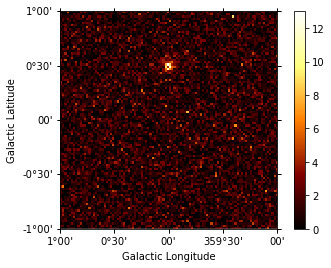

In [14]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.02, npix=(100, 100))
counts.fill_events(events)
counts.plot(add_cbar=True)

#### Fit the simulated data
We can now check the sake of the event sampling by fitting the data (a tutorial of source fitting is [here](https://docs.gammapy.org/dev/notebooks/analysis_2.html#Fit-the-model) and [here](https://docs.gammapy.org/dev/notebooks/simulate_3d)). We make use of the same `~gammapy.modeling.models.Model` adopted for the simulation. 
Hence, we firstly read the `~gammapy.datasets.Dataset` and the model file, and we fill the `~gammapy.datasets.Dataset` with the sampled events.

In [15]:
dataset = MapDataset.read("./event_sampling/dataset.fits")
models_sim_point = Models.read("./event_sampling/point-pwl.yaml")

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts
dataset.models.extend(models_sim_point)

Let's fit the data and look at the results:

In [15]:
%%time
fit = Fit([dataset])
result = fit.run(optimize_opts={"print_level": 1})
print(result)

------------------------------------------------------------------
| FCN = 7.137E+04               |     Ncalls=102 (102 total)     |
| EDM = 2.02E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : 71369.76

CPU times: user 15.3 s, s

In [16]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
norm,9.894e-01,9.154e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,1.267e-03,3.474e-03,deg,nan,nan,False
lat_0,5.023e-01,3.421e-03,deg,-9.000e+01,9.000e+01,False
index,1.998e+00,6.348e-02,,nan,nan,False
amplitude,1.042e-12,9.927e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


The results looks great!

## Extended source using a template
The event sampler can also work with a template model.
Here we use the interstellar emission model map of the Fermi 3FHL, which can be found in the GAMMAPY data repository.

We proceed following the same steps showed above and we finally have a look at the event's properties:

In [17]:
diffuse = SkyDiffuseCube.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)
models_diffuse = Models([diffuse])

file_model = "./event_sampling/diffuse.yaml"
models_diffuse.write(file_model, overwrite=True)

In [18]:
dataset = MapDataset.read("./event_sampling/dataset.fits")
dataset.models.extend(models_diffuse)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : vfVldtxv
  Datasets names            : ['E09WCx-l']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyDiffuseCube

  Name                      : gll_iem_v06_gc.fits
  Datasets names            : None
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [19]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 3.22 s, sys: 685 ms, total: 3.91 s
Wall time: 3.97 s


In [23]:
events.peek()

### How to analyze a set of event lists with DataStore
In some user case, you may want to sample events from a number of observations. 
In this section, we show how to simulate a set of event lists. For simplicity we consider only one point-like source, observed three times for 1 hr and assuming the same pointing position.

Let's firstly define the time start and the livetime of each observation:

In [20]:
tstart = [1, 5, 7] * u.hr
livetime = [1, 1, 1] * u.hr

In [21]:
for i in np.arange(len(tstart)):
    observation = Observation.create(
        obs_id=i, pointing=POINTING, 
        tstart=tstart[i], livetime=livetime[i],
        irfs=irfs
    )

    dataset = maker.run(empty, observation)
    dataset.models.extend(models_pntpwl)

    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    events.table.write(f"./event_sampling/events_{i:04d}.fits", overwrite=True)

You can now load the event list with `Datastore.from_events_files()` and make your own analysis following the instructions in [`analysis_2`](https://docs.gammapy.org/dev/notebooks/analysis_2.html) tutorial.

In [22]:
path = Path("./event_sampling/")
paths = list(path.rglob("events*.fits"))
data_store = DataStore.from_events_files(paths)
print(data_store)

Data store:
HDU index table:
BASE_DIR: .
Rows: 18
OBS_ID: 0 -- 2
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 3



<!-- ## Read simulated event lists with Datastore.from_events_lists
Here we show how to simulate a set of event lists of the same Sky model, but with different GTIs. We make use of the settings we applied previously.
Let's define the GTI firstly, chosing a time start and a duration of the observation: -->

## Exercises
- Try to sample events for an extended source (e.g. a radial gaussian morphology);
- Change the spatial model and the spectrum of the simulated Sky model;
- Include a temporal model in the simulation